# Spam Detection using Naive Bayes Algorithm

With the increasing prevalence of unsolicited and potentially harmful messages, it has become crucial to develop effective techniques for automated spam detection.

In this project, we leverage the Naive Bayes algorithm, a popular and efficient machine learning algorithm for text classification tasks. The Naive Bayes algorithm is well-suited for spam detection due to its simplicity and ability to handle high-dimensional data.

### Setup environment

In [57]:
import numpy as np
import pandas as pd

import re
import math 
import string

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus.reader.knbc import test
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/tee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the data

In [2]:
# Reading the data and removing columns that are not important. 
df = pd.read_csv('spam.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"] )
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Renaming the columns
# v1 >>> "spam_or_ham" and v2 >>> "message"
df = df.rename(columns = {"v1" : "spam_or_ham" , "v2" : "message"})  
df.columns

Index(['spam_or_ham', 'message'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   spam_or_ham  5572 non-null   object
 1   message      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### EDA

#### Exploring Target Variable - Ham or Spam

In [5]:
#number of unique target values
df.spam_or_ham.nunique()

2

In [6]:
#unique values for the target
df.spam_or_ham.unique()

array(['ham', 'spam'], dtype=object)

In [7]:
#chaning target data type to more suitable type = category
df.spam_or_ham = df.spam_or_ham.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   spam_or_ham  5572 non-null   category
 1   message      5572 non-null   object  
dtypes: category(1), object(1)
memory usage: 49.2+ KB


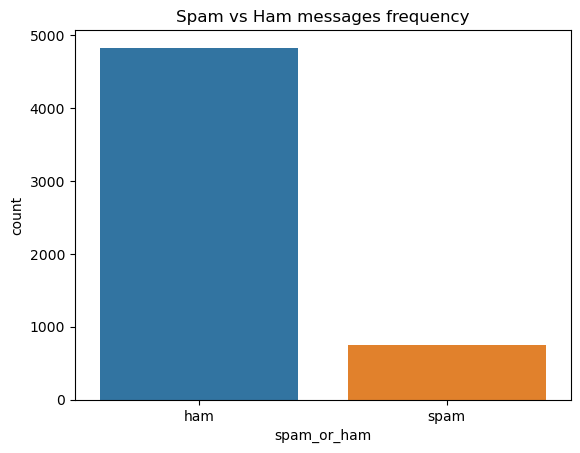

ham     4825
spam     747
Name: spam_or_ham, dtype: int64


In [8]:
plt.title("Spam vs Ham messages frequency")
sns.countplot(data=df, x ='spam_or_ham' ) 
plt.show()

print(df['spam_or_ham'].value_counts())

There is high imbalance in frequency of class labels. We have more examples of ham while very few examples of spam messages.
<br>
We will be using Naive Bayes for our analysis, and we know that this algorithm is not robust to class imbalance. 
Thus, we need to resample the data to have uniform distribution of class labels.

### Sampling

In [9]:
df_majority = df[df['spam_or_ham'] == 'ham']
df_minority = df[df['spam_or_ham'] == 'spam']
print("Inital shape: ")
print("Original data :", df.shape)
print("Majority class (ham):", df_majority.shape)
print("Minority class (spam):", df_minority.shape)

spam_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)
print()
print("Up samping spam instances : ", spam_upsample.shape)

df_upsampled = pd.concat([ df_majority, spam_upsample])  
df_upsampled = df_upsampled.sample(frac = 1)
print()
print("Sampled data :", df_upsampled.shape)

Inital shape: 
Original data : (5572, 2)
Majority class (ham): (4825, 2)
Minority class (spam): (747, 2)

Up samping spam instances :  (4825, 2)

Sampled data : (9650, 2)


In [10]:
#Ensure the distribution is equal after sampling
df_upsampled.spam_or_ham.value_counts()

ham     4825
spam    4825
Name: spam_or_ham, dtype: int64

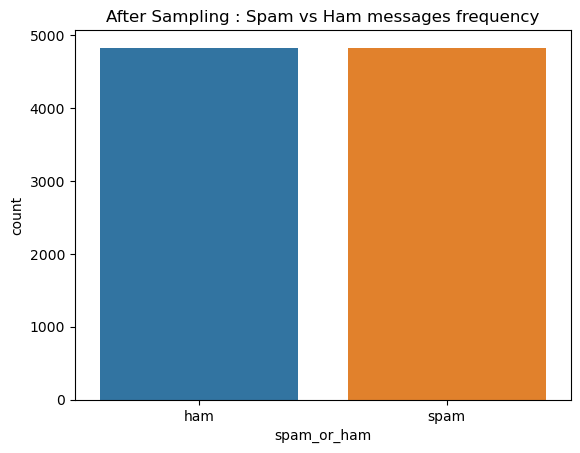

In [74]:
sns.countplot(data=df_upsampled, x='spam_or_ham')
plt.title("After Sampling : Spam vs Ham messages frequency")
plt.show()

### Train - Test Partition

In [11]:
X = df_upsampled.message
y = df_upsampled.spam_or_ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set : ", X_train.shape, y_train.shape)
print("Test set : ", X_test.shape, y_test.shape)

Train set :  (7720,) (7720,)
Test set :  (1930,) (1930,)


In [12]:
#stratify ensures consistent distribution of target variable with respect to original distribution
y_train.value_counts()

ham     3860
spam    3860
Name: spam_or_ham, dtype: int64

In [13]:
y_test.value_counts()

ham     965
spam    965
Name: spam_or_ham, dtype: int64

### Preprocess the text
1. Text data contains a lot of redundant and unncessary information like stopwords, links, punctations. <br>
2. Uniform case of all the words. "Hello" is same as "hello". <br>
3. Perform stemming. The stem of the words eating, eats, eaten is eat.

In [14]:
def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 
    '''
    
    stopwords = nltk.corpus.stopwords.words('english')
    ps = nltk.PorterStemmer()
    
    message = re.sub(r"(www|http:|https:)+[\S]+[\w]+", "", message)
    messages_cleaned = "".join([word.lower() for word in message if word not in string.punctuation])
    tokens = re.split("\W+",messages_cleaned)
    messages_cleaned = [ps.stem(word) for word in tokens if word not in stopwords]

    return messages_cleaned

In [15]:
#test on random string
test_str = "hello! Testing CLEAN function. I hope it works! http://testurl.com www.wow.com okay! working..."
print("processed string: ", clean_message(test_str))

processed string:  ['hello', 'test', 'clean', 'function', 'hope', 'work', 'okay', 'work']


In [16]:
messages = ['get offer upto 20%', 'I am coming now', 'Click on the link www.viv', 'get a latest car', 'canvas class scheduled']
for m in messages:
    print(clean_message(m))

['get', 'offer', 'upto', '20']
['come']
['click', 'link', '']
['get', 'latest', 'car']
['canva', 'class', 'schedul']


In [17]:
#try on train data sample
custom_message = X_train.iloc[0]
print("Original message: ",custom_message)
print()
print("Processed message: ",clean_message(custom_message))

Original message:  SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO

Processed message:  ['sm', 'ac', 'jsco', 'energi', 'high', 'u', 'may', 'know', '2channel', '2day', 'ur', 'leadership', 'skill', 'r', 'strong', 'psychic', 'repli', 'an', 'wquestion', 'end', 'repli', 'end', 'jsco']


### Encoding class label
We have outputs as 'ham' or 'spam'. In the cell below, we convert it to a numerical format. 

In [20]:
output_map = {'ham': 0, 'spam': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

### Compute probability of occurrence of a word, for the given class label
- The probability of occurrence of a word, given that the output is 'spam'.
- The probability of occurence of a word, given that the output is 'ham'.

In [21]:
def message_counter(output_occurrence, messages, spam_or_ham):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        messages: a list of messages
        spam_or_ham: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    for label, message in zip(spam_or_ham, messages):
        for word in clean_message(message):
            key = (word,label)
            if key in output_occurrence :
                  output_occurrence[key] += 1 #{word,label : count}
            else :
                  output_occurrence[key] = 1
    return output_occurrence

In [22]:
# Testing with random messages
result = {}
messages = ['get offer upto 20%', 'I am coming now', 'Click on the link www.viv', 'get a latest car', 'canvas class scheduled']
cls = [1, 0, 1, 1, 0]
message_counter(result,messages, cls)

{('get', 1): 2,
 ('offer', 1): 1,
 ('upto', 1): 1,
 ('20', 1): 1,
 ('come', 0): 1,
 ('click', 1): 1,
 ('link', 1): 1,
 ('', 1): 1,
 ('latest', 1): 1,
 ('car', 1): 1,
 ('canva', 0): 1,
 ('class', 0): 1,
 ('schedul', 0): 1}

### Frequency Dictionary
- the frequency of occurrence of word given that a message is 'spam'.
- the frequence of occurence of word given that a message is 'ham'.

In [48]:
def print_dict_few(dict_data, max_count):
    count = 0
    for key, value in dict_data.items():
        print(key, ":", value)
        count += 1
        if count == max_count:
            break

freqs = message_counter({}, X_train, y_train)
print_dict_few(freqs, 5)

('sm', 1) : 134
('ac', 1) : 28
('jsco', 1) : 12
('energi', 1) : 22
('high', 1) : 13


In [18]:
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    key = (word,label)
    #print(key)
    if key in frequency.keys():
        n = frequency[key] 
    else :
        n = 0
    return n

In [24]:
find_occurrence(freqs, "energi", 1)

22

### Train Naive Bayes
Calculate Log Likelihood and Log prior values

In [49]:
def generate_vocab(data):
      '''
      generates vocab from frequency dict
      '''
      vocab = set()
      for pair in data:
        word = pair[0]
        vocab.add(word)
      return vocab

def train_naive_bayes(frequency_dict, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of messages
        train_y: a list of labels correponding to the messages (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = generate_vocab(freqs)
    V = len(vocab)

    # calculate num_pos and num_neg => the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in frequency_dict.keys():

        # if the label is positive (greater than zero)
        if pair[1] == 1:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = num_pos + 1
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg = num_neg + 1

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = len([ y for y in y_train if y == 1])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = len([ y for y in y_train if y == 0])

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    print("+",num_pos)
    print("-",num_neg)
    print("+doc",pos_num_docs)
    print("-doc",neg_num_docs)
    print("doc", num_doc)
    print("vocab", V)
    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(frequency_dict,word,1)
        freq_neg = find_occurrence(frequency_dict,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos + V)
        p_w_neg = (freq_neg+1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [51]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)

+ 2629
- 5500
+doc 3860
-doc 3860
doc 7720
vocab 7277


In [53]:
print("Log prior : ", logprior)
print("Log likelihood : ", len(loglikelihood))

Log prior :  0.0
Log likelihood :  7277


### Predictions
The output is 1 (spam) if the sum of the log likelihood value is greater than 0 and 0 (ham) if the sum of the log likelihood is less than or equal to 0. 

In [55]:
def naive_bayes_predict(message, logprior, loglikelihood):
    '''
    Params:
        message: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the message (if found in the dictionary) + logprior (a number)

    '''
    # process the message to get a list of words
    word_l = clean_message(message)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += (logprior)

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            #print(loglikelihood[word], word)
            total_prob = total_prob + loglikelihood[word]
            total_prob = format_log(total_prob)
    return total_prob

def format_log(prob):
  if prob > 0 :
    return 1
  else :
    return 0

In [56]:
msg = 'She smiled.'
p = naive_bayes_predict(msg, logprior, loglikelihood)
print('The expected output for message \"',msg ,'\" is', p)

msg = 'Offer! Limited period! free iphone.'
p = naive_bayes_predict(msg, logprior, loglikelihood)
print('The expected output for message \"',msg ,'\" is', p)

The expected output for message " She smiled. " is 0
The expected output for message " Offer! Limited period! free iphone. " is 1


In [67]:
#more examples
for message in ['get an offer', 'get the latest movie review', 'order iphone', 'I am on a meeting']:
    p = naive_bayes_predict(message, logprior, loglikelihood)
    print(f'{message} -> {p}')

get an offer -> 1
get the latest movie review -> 1
order iphone -> 1
I am on a meeting -> 0


### Testing

In [65]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of messages
        test_y: the corresponding labels for the list of messages
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of messages classified correctly)/(total # of message)
    """
    accuracy = 0  
    
    y_hats = []
    for message in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(message, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0
        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    y_hats = np.array(y_hats)
    test_y = np.array(test_y)
    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1 - error
   
    return accuracy

#print(test_naive_bayes(X_test, y_test, logprior, loglikelihood))
acc = test_naive_bayes(X_test, y_test, logprior, loglikelihood)
print("Accuracy : ", round(acc*100,4), "%")

Accuracy :  79.0155 %


### Additional Info

#### **Laplace Smoothing / Additive Smoothing**

Laplace Smoothing or Additive Smoothing is used to solve the problem of zero probability for the test data, i.e. when the model receives a new observation, which is not seen in training data.


---


Naive Bayes predicts using the following formula :- 

**P(c|x) = P(x|c) P(c) ÷ P(x)**   

where

P(c|x) : Posterior Probability

P(x|c) : Likelihood

P(c)   : Class Prior Probability

P(x)   : Predictor Prior Probability

---

**Example** 

Consider a model that predicts positive and negative reviews.

Let r1, r2, r3 be words in review available in training data with positive label.

and let r1, r2 be words in training data with negative label.

Thus, P(r1|pos), P(r2|pos) and P(r3|pos) exists.

While P(r1|neg), P(r2|neg) exists 

but  P(r3|neg) = 0 since there is no training data r3 for neg. 


Suppose query for testing is review : r1 r3 r2.

P(pos | review) = P(pos) × P(r1|pos) × P(r3|pos) ×  P(r2|pos) be some positive value.

P(neg | review) = P(neg) × P(r1|neg) × P(r3|neg) ×  P(r2|neg) = 0

This will always be zero, irrespective of the value of P(neg) or P(r1|neg), P(r2|neg). 

This is because {r3, neg} was not present in training data.


If any further reviews contain r3 as word, it will not be classified as negative, i.e. it will always be classified as positive review irrespective of other negative words presents in the review message. 


---


To solve such zero probability problem, we use Laplace Smoothing or Additive Smoothing.

A small-sample correction α, or pseudo-count, (generally α=1) is incorporated in every probability estimate. This will ensure that no probability will be zero.

Thus, after correction we can correctly predict label the label of the reviews using Naive Bayes irrespective of the fact that is present in training data or not.

#### **Naive Bayes uses Logarithmic values over Probablistic vallues.**

Naive Bayes predicts using the following formula :- 

**P(c|x) = P(x|c) P(c) ÷ P(x)**   

where

P(c|x) : Posterior Probability

P(x|c) : Likelihood

P(c)   : Class Prior Probability

P(x)   : Predictor Prior Probability



---


Applying Naive Bayes for classes C1, C2 ... , Cn and set of features, F1, ... , Fm.

Prediction = argmax(i) P(F1,F2,...,Fm | Ci)P(Ci)

Prediction = argmax(i) [ P(F1|Ci) × P(F2|Ci) × ... × P(Fm|Ci) ]P(Ci)



When the dataset is with large vocabulary (m), we face a computation problem for the above equation.

Since each P(Fj|Ci) for j = [1:m] is between 0 and 1,

when we take product of such small decimal values, the overall value tends to zero.

This gets worse by each new feature that is added, as resultant product of probabilities of large features result in very small value, which often cannot be
represented in a float/double or long double.
Every language that uses a standard floating-point data type with a fixed number of bits will eventually
run out of precision with extremely small numbers.



---

To overcome this situation, probabilities are represented as log-probabilities instead.




*   Wider range : A probability is always between 0 and 1, but a log-probability is always between -∞ and 0. 
*   Comparison is preserved : If a < b, then ln a < ln b.
*   Easy computation : The logarithm of a product is the sum of the logarithms. The resulting sums (rather than products) are usually manageable numbers.
Prediction = argmax(i) { ln [P(F1|Ci)] × ln [P(F2|Ci)] × ... × ln[P(Fm|Ci)] } ln[P(Ci)]

